In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import ADASYN
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/IDS_Data/CICIDS2017.csv")
d = pd.read_csv("/content/drive/MyDrive/IDS_Data/CICIDS2017_sample.csv")

In [4]:
d

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [5]:
# Check the distribution of labels
label_counts = df['Label'].value_counts()
print(label_counts)

0    18225
3     3042
6     2180
1     1966
5     1255
2       96
4       36
Name: Label, dtype: int64


In [6]:
# Split the data into features (X) and labels (y)
X = df.drop(['Label'], axis=1)
y = df['Label']

In [7]:
# Label encoding for XGBClassifier
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [9]:
# Apply ADASYN for oversampling
adasyn = ADASYN(n_jobs=-1, sampling_strategy={2: 1000, 4: 1000})
X_train, y_train = adasyn.fit_resample(X_train, y_train)

In [10]:
# Normalize data for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Train the XGBoost algorithm
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [12]:
# Neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of classes

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9984      
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 10,887
Trainable params: 10,887
Non-trainable params: 0
_________________________________________________________________


In [14]:
# One-hot encode y_train and y_test for neural network
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [15]:
history = model.fit(X_train_scaled, y_train_encoded, batch_size=32, epochs=50, verbose=1, validation_data=(X_test_scaled, y_test_encoded))
predictions = model.predict(X_test_scaled)

Epoch 1/50
729/729 [==============================] - 3s 3ms/step - loss: 0.4296 - accuracy: 0.8356 - val_loss: 0.2634 - val_accuracy: 0.8950
Epoch 2/50
729/729 [==============================] - 2s 3ms/step - loss: 0.2471 - accuracy: 0.8943 - val_loss: 0.2150 - val_accuracy: 0.9325
Epoch 3/50
729/729 [==============================] - 2s 2ms/step - loss: 0.2135 - accuracy: 0.9088 - val_loss: 0.2147 - val_accuracy: 0.8965
Epoch 4/50
729/729 [==============================] - 1s 2ms/step - loss: 0.1978 - accuracy: 0.9145 - val_loss: 0.1987 - val_accuracy: 0.9190
Epoch 5/50
729/729 [==============================] - 2s 2ms/step - loss: 0.1860 - accuracy: 0.9216 - val_loss: 0.1795 - val_accuracy: 0.9287
Epoch 6/50
729/729 [==============================] - 1s 2ms/step - loss: 0.1774 - accuracy: 0.9255 - val_loss: 0.1769 - val_accuracy: 0.9362
Epoch 7/50
729/729 [==============================] - 1s 2ms/step - loss: 0.1707 - accuracy: 0.9272 - val_loss: 0.1779 - val_accuracy: 0.9220
Epoch 

In [16]:
# Convert predictions to class labels
y_pred_nn = label_encoder.inverse_transform(predictions.argmax(axis=1))

In [17]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

In [18]:
# Evaluate the performance of Neural Network Model
print("Max Pooling 1D: ")
print(classification_report(y_test, y_pred_nn))
print("Accuracy of IDS:", accuracy_score(y_test, y_pred_nn))
print("Precision of IDS:", precision_score(y_test, y_pred_nn, average='weighted'))
print("Recall of IDS:", recall_score(y_test, y_pred_nn, average='weighted'))
print("Average F1 of IDS:", f1_score(y_test, y_pred_nn, average='weighted'))
print("F1 of Logistic Regression based IDS for each type of attack:", f1_score(y_test, y_pred_nn, average=None))

Max Pooling 1D: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3656
           1       0.83      0.99      0.90       387
           2       0.18      0.93      0.30        14
           3       0.96      0.95      0.95       612
           4       0.60      0.38      0.46         8
           5       0.86      0.96      0.91       231
           6       0.96      0.91      0.93       452

    accuracy                           0.95      5360
   macro avg       0.77      0.87      0.77      5360
weighted avg       0.96      0.95      0.95      5360

Accuracy of IDS: 0.9455223880597015
Precision of IDS: 0.9565899628295303
Recall of IDS: 0.9455223880597015
Average F1 of IDS: 0.9494367207044294
F1 of Logistic Regression based IDS for each type of attack: [0.96201475 0.90352941 0.30232558 0.95308642 0.46153846 0.90612245
 0.93287827]


In [19]:
# Evaluate the performance of Ensemble Model
print("Extreme Gradient Boosting: ")
print(classification_report(y_test, y_pred))
print("Accuracy of IDS: " + str(accuracy_score(y_test, y_pred)))
print("Precision of IDS: " + str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of IDS: " + str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of IDS: " + str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of Ensembled Model IDS for each type of attack: " + str(f1_score(y_test, y_pred, average=None)))

Extreme Gradient Boosting: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.99      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.75      0.86         8
           5       0.99      1.00      0.99       231
           6       1.00      1.00      1.00       452

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.98      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of IDS: 0.9975746268656717
Precision of IDS: 0.9975785111962567
Recall of IDS: 0.9975746268656717
Average F1 of IDS: 0.9975484116918976
F1 of Ensembled Model IDS for each type of attack: [0.99835931 0.99222798 1.         0.99918367 0.85714286 0.99137931
 0.99889258]


In [20]:
# Get the unique attack types
attack_types = df['Label'].unique()

In [21]:
# Create a dictionary to map attack labels to attack types
label_to_attack = dict(zip(range(len(attack_types)), attack_types))

In [22]:
# Map the predicted labels to attack types
predicted_attacks = [label_to_attack[label] for label in y_pred]

In [23]:
# Map the true labels to attack types
true_attacks = [label_to_attack[label] for label in y_test]

In [24]:
# Display the predicted and true attack types
print("Predicted Attacks:", predicted_attacks)
print("True Attacks:     ", true_attacks)

Predicted Attacks: [0, 3, 0, 2, 0, 2, 3, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 0, 4, 3, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 0, 0, 0, 0, 4, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 6, 3, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 2, 6, 2, 3, 0, 6, 6, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 5, 0, 0, 2, 0, 6, 3, 6, 6, 0, 0, 0, 0, 0, 6, 0, 0, 4, 2, 6, 3, 0, 2, 0, 3, 2, 0, 2, 0, 3, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 6, 3, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 0, 0, 0, 0, 2, 2, 2, 0, 6, 0, 6, 2, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 4, 6, 0, 4, 0, 0, 6, 6, 2, 0, 0, 0, 3, 0, 6, 0, 0, 2, 6, 3, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 2, 0, 2, 6,

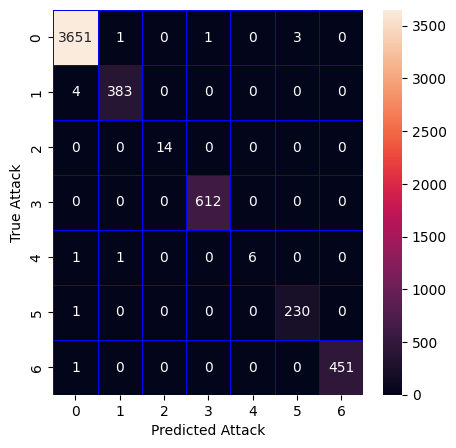

In [25]:
# Plot the confusion matrix
cm = confusion_matrix(true_attacks, predicted_attacks, labels=attack_types)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="blue", fmt="d", ax=ax)
plt.xlabel("Predicted Attack")
plt.ylabel("True Attack")
plt.show()